In [14]:
import numpy as np
from scipy import *
from pylab import *
import os
from scipy import interpolate,stats
from scipy.integrate import quad
import scipy.optimize as op
import sys, os
import hmf

In [5]:
Mpc=3.086e+24#cm
c = 299792.458#km/s
Gnewton = 6.674e-8#cgs cm^3/g/s^2
H0 = 70.0#67.74
h = H0/100.0
OmegaM = 0.30#1#Planck15 TT,TE,EE+lowP+lensing+ext
OmegaV = 1.0-OmegaM
#rho_c0 = 9.9e-30#g/cm^3
M_sun = 1.989e33#gram
# growth factor
Hcgs = lambda z: H0*sqrt(OmegaM*(1+z)**3+OmegaV)*3.24e-20
H_inv = lambda z: 1.0/(H0*sqrt(OmegaM*(1+z)**3+OmegaV))
# luminosity distance Mpc
DC_integral = lambda z: c*quad(H_inv, 0, z)[0]
z_arr = linspace(0.0, 2.0, 201)
DC_arr0 = array([DC_integral(z) for z in z_arr])
DC = interpolate.interp1d(z_arr, DC_arr0)
DA = lambda z: DC(z)/(1.0+z)
DL = lambda z: DC(z)*(1.0+z)
##rho_cz = lambda z: rho_c0*(OmegaM*(1+z)**3+(1-OmegaM))
rho_cz = lambda z: 0.375*Hcgs(z)**2/pi/Gnewton#critical density
dd = lambda z: OmegaM*(1+z)**3/(OmegaM*(1+z)**3+OmegaV)
Delta_vir = lambda z: 18.0*pi**2+82.0*dd(z)-39.0*dd(z)**2
Rvir_fcn = lambda Mvir, z: (0.75/pi * Mvir*M_sun/(Delta_vir(z)*rho_cz(z)))**0.3333

In [6]:
###### source galaxies ######
z0 = 0.4 ## mean redshift 
ngal_mean = 20 ## number density in unit of arcmin^-2
zlo, zhi= 0, 2.0 ## the redshift cuts
Pz = lambda z: 0.5*z**2/z0**3*exp(-z/z0) ## P(z)
z_choices = linspace(zlo,zhi,101) ## center of z bins
prob = Pz(z_choices)
prob /= sum(prob)
## redshift and Ngal generator
redshift_gen = lambda N: np.random.choice(z_choices, size=N, p=prob)
Ngal_gen = lambda N: np.random.poisson(N)

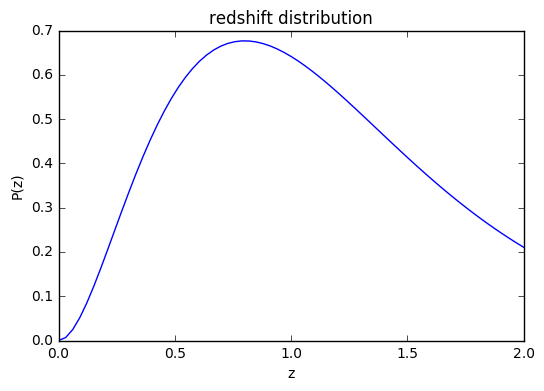

In [11]:
z_arr = linspace(0,3,100)
plot(z_arr,Pz(z_arr))
xlabel('z');ylabel('P(z)')
xlim(0,2)
title('redshift distribution')
show()

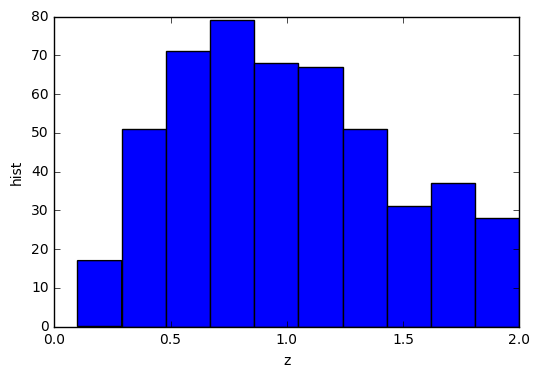

In [12]:
sample = redshift_gen(500)
hist(sample);xlabel('z');ylabel('hist');show()

In [15]:
###### halo mass function ######
Mmin, Mmax, dlog10m=12, 15, 0.05
dndm_arr = array([hmf.MassFunction(z=iz, Mmin=Mmin, Mmax=Mmax, dlog10m=dlog10m).dndm for iz in z_choices])
# save('dndm_arr.npy',dndm_arr)
z_arr, M_arr = z_choices, arange(Mmin,Mmax,dlog10m)
#dndm_arr = load('dndm_arr.npy')
dndm_arr /= sum(dndm_arr,axis=1).reshape(-1,1)

z_lens = redshift_gen(1) ## lens redshift
M_lens = np.random.choice(M_arr, p=dndm_arr[z_arr==z_lens][0]) ## find lens mass
### HOD
A, B, C = 47.0, 0.85, -0.1
N_lens_fcn = lambda logM, z: A*(10**(logM-14.0)/h)**B*(1+z)**C - 1.0
N_lens = int(N_lens_fcn(M_lens, z_lens) + 0.5)
print M_lens, z_lens, N_lens
Cvir = lambda logM, z: 10**(0.537+0.488*exp(-0.718*z**1.08)+(-0.097+0.024*z)* (logM-12-log10(2.0/h))  )

12.2 [ 1.2] 1


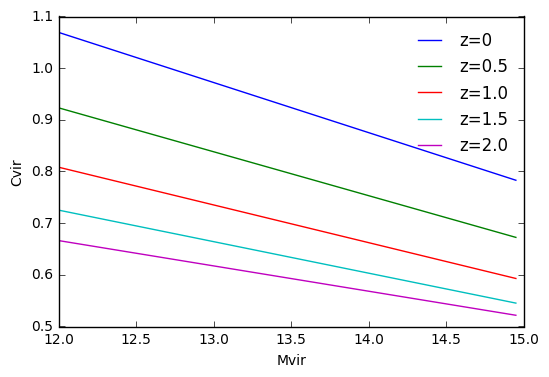

In [16]:
Mmin, Mmax, dlog10m=12, 15, 0.05
M_arr=arange(Mmin,Mmax,dlog10m)
[plot(M_arr, log10(Cvir(M_arr, iz)), label='z=%s'%(iz)) for iz in (0,0.5,1.0,1.5,2.0)]
xlabel('Mvir')
ylabel('Cvir')
legend(frameon=0)
show()